### Creating Tiles For Fatih District 

Download tiles from OpenStreetMaps which are 256x256 which can be compatible with Road Segmentation Model

In [17]:
# !pip install rasterio

In [ ]:
## Functions

from math import log, tan, radians, cos, pi, floor, degrees, atan, sinh


def sec(x):
    return(1/cos(x))


def latlon_to_xyz(lat, lon, z):
    tile_count = pow(2, z)
    x = (lon + 180) / 360
    y = (1 - log(tan(radians(lat)) + sec(radians(lat))) / pi) / 2
    return(tile_count*x, tile_count*y)


def bbox_to_xyz(lon_min, lon_max, lat_min, lat_max, z):
    x_min, y_max = latlon_to_xyz(lat_min, lon_min, z)
    x_max, y_min = latlon_to_xyz(lat_max, lon_max, z)
    return(floor(x_min), floor(x_max),
           floor(y_min), floor(y_max))


def mercatorToLat(mercatorY):
    return(degrees(atan(sinh(mercatorY))))


def y_to_lat_edges(y, z):
    tile_count = pow(2, z)
    unit = 1 / tile_count
    relative_y1 = y * unit
    relative_y2 = relative_y1 + unit
    lat1 = mercatorToLat(pi * (1 - 2 * relative_y1))
    lat2 = mercatorToLat(pi * (1 - 2 * relative_y2))
    return(lat1, lat2)


def x_to_lon_edges(x, z):
    tile_count = pow(2, z)
    unit = 360 / tile_count
    lon1 = -180 + x * unit
    lon2 = lon1 + unit
    return(lon1, lon2)


def tile_edges(x, y, z):
    lat1, lat2 = y_to_lat_edges(y, z)
    lon1, lon2 = x_to_lon_edges(x, z)
    return[lon1, lat1, lon2, lat2]


In [19]:
import math
import urllib.request
import os
import glob
import subprocess
import shutil
from osgeo import gdal

import rasterio
from matplotlib import pyplot as plt

In [4]:
# Create an an account on Mapbox and get your access token key. Replace "MAPBOX_ACCESS_TOKEN" with the token key

tile_server = "https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token=" + os.environ.get('MAPBOX_ACCESS_TOKEN')

In [6]:
temp_dir = os.path.join(os.path.dirname(__file__), 'temp')
output_dir = os.path.join(os.path.dirname(__file__), 'output')

In [7]:
# Setting coordinates of Fatih district
zoom = 18
lon_min = 28.919255
lon_max = 28.987703
lat_min = 40.988008
lat_max = 41.040811

In [8]:

def download_tile(x, y, z, tile_server):
    url = tile_server.replace(
        "{x}", str(x)).replace(
        "{y}", str(y)).replace(
        "{z}", str(z))
    path = f'{temp_dir}/{x}_{y}_{z}.png'
    urllib.request.urlretrieve(url, path)
    return(path)


def merge_tiles(input_pattern, output_path):
    merge_command = ['gdal_merge.py', '-o', output_path]

    for name in glob.glob(input_pattern):
        merge_command.append(name)

    subprocess.call(merge_command)


def georeference_raster_tile(x, y, z, path):
    bounds = tile_edges(x, y, z)
    filename, extension = os.path.splitext(path)
    gdal.Translate(filename + '.tif',
                   path,
                   outputSRS='EPSG:4326',
                   outputBounds=bounds)

In [10]:
x_min, x_max, y_min, y_max = bbox_to_xyz(
    lon_min, lon_max, lat_min, lat_max, zoom)

print(f"Downloading {(x_max - x_min + 1) * (y_max - y_min + 1)} tiles")
for x in range(x_min, x_max + 1):
    for y in range(y_min, y_max + 1):
        print(f"{x},{y}")
        png_path = download_tile(x, y, zoom, tile_server)
        georeference_raster_tile(x, y, zoom, png_path)

print("Download complete")


In [ ]:
# Merging tiles
print("Merging tiles")
merge_tiles(temp_dir + '/*.tif', output_dir + '/merged.tif')
print("Merge complete")

shutil.rmtree(temp_dir)
os.makedirs(temp_dir)

In [13]:
# Visualizing some of the downloaded tiles

def show_raster(raster_src):
  src1 = rasterio.open(raster_src)
  print(src1.shape)
  plt.imshow(src1.read(1), cmap = 'pink')
  plt.plot()


(256, 256)


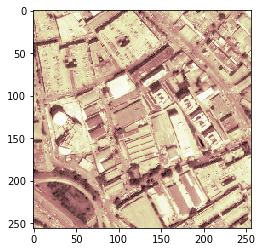

In [23]:
images = "/home/ivoline/Documents/Omdena/Earthquake/earthquake/road_segmentation/Tiles/tiles-to-tiff-master/temp/38032_24561_16.tif"
show_raster(images)

(256, 256)


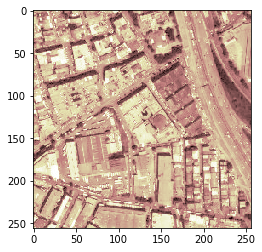

In [21]:
images = "/temp/38032_24563_16.tif"
show_raster(images)

(256, 256)


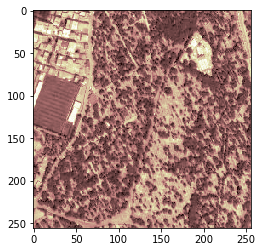

In [20]:
# Visualizing some of the downloaded tiles
images = "/temp/38032_24568_16.tif"
show_raster(images)

Reference: https://dev.to/jimutt/generate-merged-geotiff-imagery-from-web-maps-xyz-tile-servers-with-python-4d13